In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, sin, exp, pi
from scipy.stats import norm
import seaborn as sns
sns.set_style("whitegrid", {'grid.linestyle': '--'})

## 3.1 線形基底関数モデル

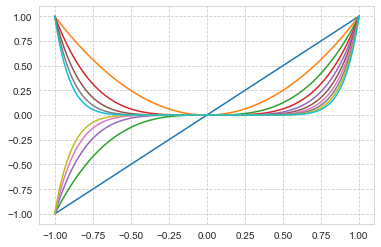

In [2]:
# 基底関数：多項式
y = 0
x = np.linspace(-1, 1, 100)
for i in range(1, 11):
    y = x**i
    plt.plot(x, y)

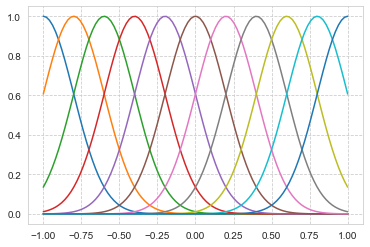

In [3]:
# 基底関数：ガウス基底関数
y = 0
x = np.linspace(-1, 1, 100)
for mu in np.linspace(-1, 1, 11):
    y = exp(-(x-mu)**2/ (2*(0.2)**2))
    plt.plot(x, y)


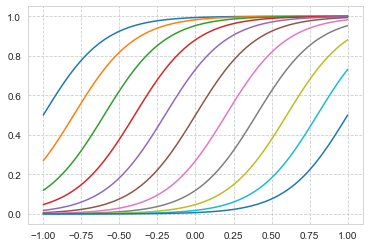

In [4]:
# 基底関数：シグモイド関数
for mu in np.linspace(-1, 1, 11):
    y = 1 / (1+exp(-((x-mu) / 0.2)))
    plt.plot(x, y)

## 3.2 バイアス-バリアンス分解

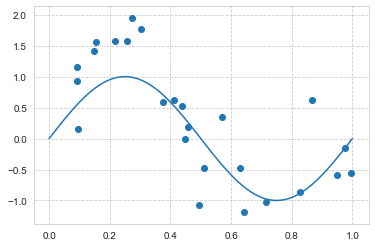

In [5]:
N = 25
L = 100
M = 25
x_array= np.random.rand(L, N)
t_array = sin(2*pi*x_array)+np.random.normal(0, 0.5, (L, N))
x_r = np.linspace(0, 1, 100)
t_r = sin(2*pi*x_r)
plt.plot(x_r, t_r)
plt.scatter(x_array[0, :], t_array[0, :])

In [6]:
sigma = 0.1
phi = np.zeros((L, N, M))
for i in range(L):
    for j, mu in enumerate(np.linspace(-1, 2, M)):
        phi[i, :, j] = exp(-(x_array[i, :]-mu)**2 / (2*(sigma)**2))

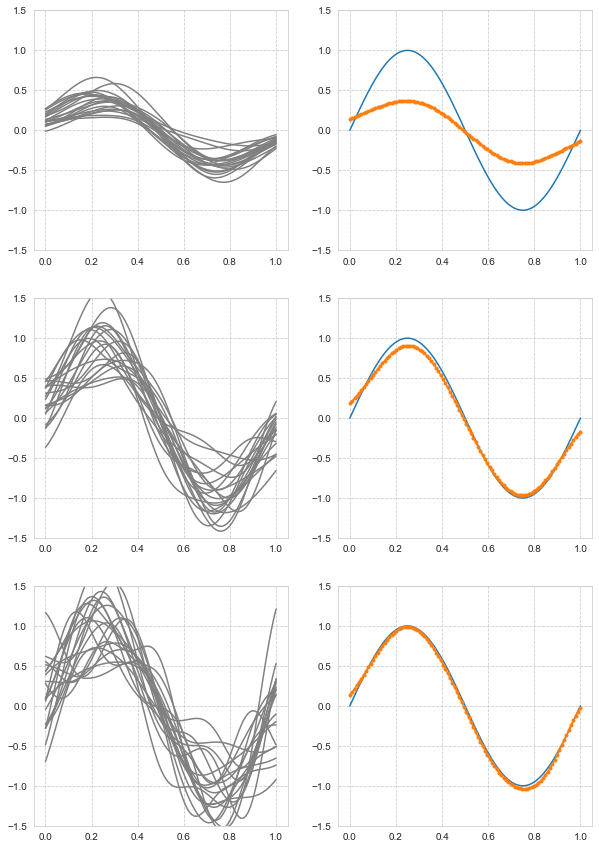

In [7]:
fig = plt.figure(figsize=(10, 15))
for k, lam in enumerate(exp([2.6, -0.31, -2.4])):
    y_mean = 0
    plt.subplot(3, 2, 2*k+1)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.5, 1.5)
    for i in range(20):
        y = 0
        x = x_array[i]
        t = t_array[i]
        w = np.linalg.inv(lam*np.identity(N) + phi[i, :, :].T @ phi[i, :, :]) @ phi[i, :, :].T @ t
        for j, mu in enumerate(np.linspace(-1, 2, M)):
            y += w[j] * exp(-(x_r-mu)**2 / (2*(sigma)**2))
        y_mean += y
        plt.plot(x_r, y, color='gray')
    y_mean /= 20
    plt.subplot(3, 2, 2*k+2)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.5, 1.5)
    plt.plot(x_r, t_r)
    plt.plot(x_r, y_mean, marker='.')


## 3.3 ベイズ線形回帰

In [8]:
# 多次元乱数生成用の棄却サンプリング

def sample_MD(c, p, N, M):
    p /= p.max()
    samples = []
    for i in range(1000000):
        a = np.random.choice(np.arange(len(c)), M)
        if np.random.rand() < p[tuple(a[::-1])]:
            samples.append(c[a])
        if len(samples) == N:
            break
    return np.array(samples)

3.3.1 パラメータの分布

(-1, 1)

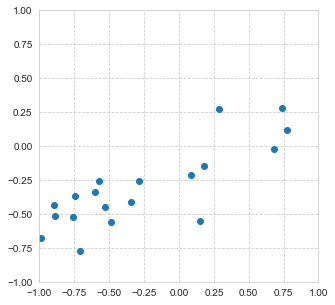

In [9]:
N = 20
a = [-0.3, 0.5]
x = 2 * np.random.rand(N) - 1
t = a[0] + a[1] * x + np.random.normal(0, 0.2, N)
plt.figure(figsize=(5, 5))
plt.scatter(x, t)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

C:\Users\Asunaro\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Asunaro\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Asunaro\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In

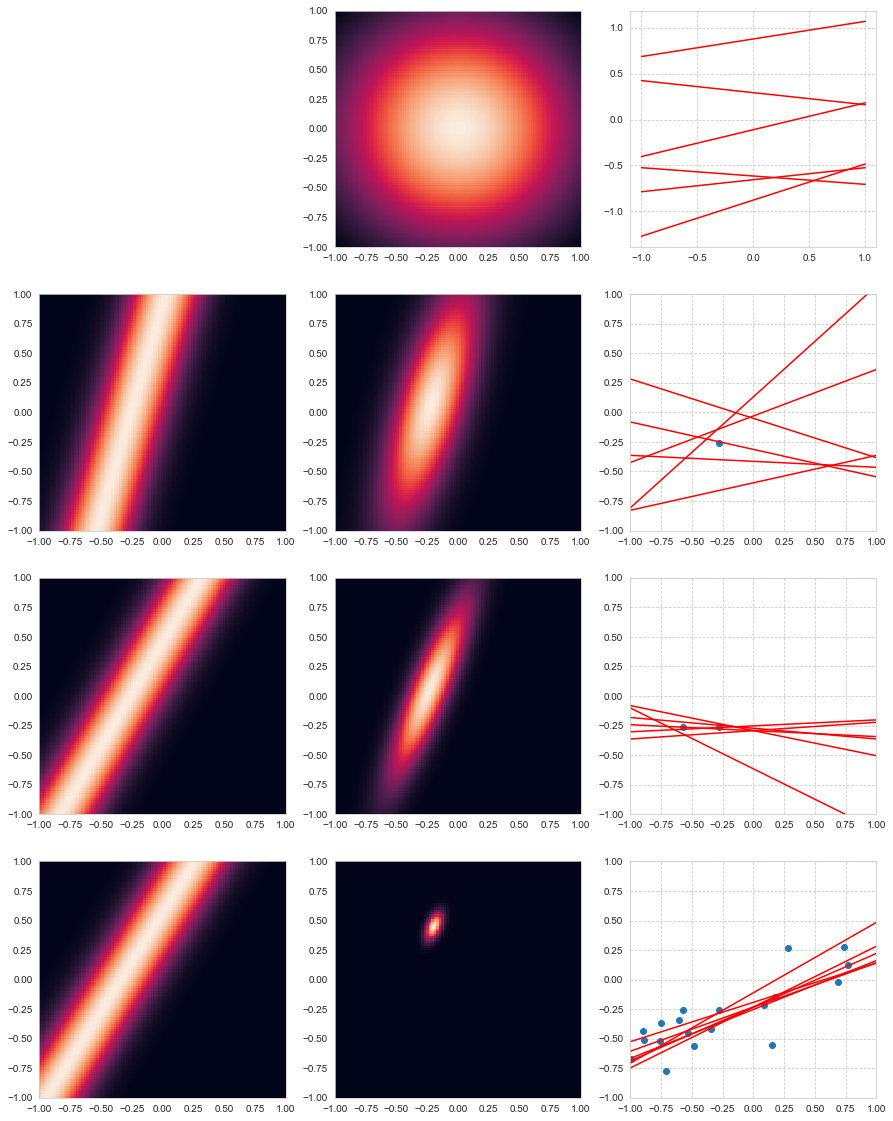

In [10]:
plt.figure(figsize=(15, 20))

alpha = 2.0
beta = 25
M = 2
w_line = np.linspace(-1, 1, 100)
W = np.meshgrid(w_line, w_line)


# 学習前
P_pri = alpha**(1/2) / (2*pi) * exp(-W[0]**2-W[1]**2)
plt.subplot(4, 3, 2)
plt.pcolormesh(W[0], W[1], P_pri)

x_line = np.linspace(-1, 1, 100)
for i in range(6):
    w = sample_MD(w_line, P_pri, 6, M)
    y = w[i, 0] + w[i, 1] * x_line
    plt.subplot(4, 3, 3)
    plt.plot(x_line, y, color='red')

# 学習後

for i, N in enumerate([1, 2, 20]):
    P_like = 1
    for n in range(N):
        p_l = beta**(1/2) / (2*pi) * exp(- beta/2 * (t[n] - (W[0] + W[1] * x[n]))**2)
        P_like *= p_l
    plt.subplot(4, 3, 3*i+4)
    plt.pcolormesh(W[0], W[1], p_l)
    P_post = P_pri * P_like
    P_post /= P_post.max()
    plt.subplot(4, 3, 3*i+5)
    plt.pcolormesh(W[0], W[1], P_post)
    w = sample_MD(w_line, P_post, 6, M)
    plt.subplot(4, 3, 3*i+6)
    for i in range(6):
        y = w[i, 0] + w[i, 1] * x_line
        plt.plot(x_line, y, color='red')
    plt.scatter(x[:N], t[:N])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    P_pri = P_post.copy()